# <center>CS 7324 Lab 7
## <center>Francesco Trozzi (47779944) - George Sammit (04010135) - Megan Simons (46334773)

# General

## Imports

In [51]:
#General
import numpy as np
import pandas as pd 
import os

#Pre-processing
from bs4 import BeautifulSoup

#Utilites
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

# Modeling
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Input, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

#For plotting
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### Constants

In [52]:
NUM_TOP_WORDS = 5000 # Could be modified durning tokenization
MAX_ART_LEN = 800 # Calculated below

NEG_SENTIMENT = 0
POS_SENTIMENT = 1

NUM_CLASSES = 2
EMBED_SIZE = 25
EPOCHS = 25

# Pre-processing
### Load data (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [53]:
df = pd.read_csv('IMDB Dataset.csv')

In [54]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Remove html markups

We notice the presence of html markups, which we remove using the code found in:
https://stackoverflow.com/questions/44703945/pandas-trouble-stripping-html-tags-from-dataframe-column

In [55]:
df['review'] = [BeautifulSoup(text).get_text() for text in df['review'] ]

In [56]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Case-sensitvity and punctuation

We then removed all the punctuation and transform every letter to lower-case. The reason is we do not want a case sensitive classification, which would greatly increase the number of words, and characters such as punctuation which do not carry any meaning. 
Example taken from: https://medium.com/@lamiae.hana/a-step-by-step-guide-on-sentiment-analysis-with-rnn-and-lstm-3a293817e314

In [57]:
from string import punctuation
df['review'] = [text.lower() for text in df['review']]
df['review'] = df['review'].str.replace('[{}]'.format(punctuation), ' ')

In [58]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is...,positive


In [59]:
meaningless = [' at ', ' in ', ' on ', ' s ', ' a ', ' an ', ' the ']
df['review'] = [' '+text for text in df['review']]

In [60]:
for m in meaningless:
    df['review'] = df['review'].str.replace(m, ' ')

In [61]:
df.head()

,review,sentiment
0,one of other reviewers has mentioned that aft...,positive
1,wonderful little production filming techniqu...,positive
2,i thought this was wonderful way to spend tim...,positive
3,basically there family where little boy jake...,negative
4,petter mattei love time of money is visuall...,positive


### Vizualize the length distribution

In [62]:
split = df['review'].str.split()

In [63]:
lengths = split.apply(len)
lengths.describe(percentiles=[.5, .75, .9, .95, .99])

count    50000.000000
mean       206.298920
std        151.702356
min          4.000000
50%        155.000000
75%        250.000000
90%        401.000000
95%        523.000000
99%        802.010000
max       2145.000000
Name: review, dtype: float64

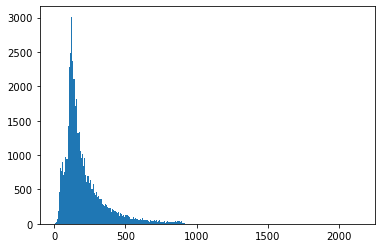

In [64]:
plt.hist(lengths, bins='auto')
plt.show()

Baseded on the above, we chose a length of 2,000.  About 1/2 of the reviews are approximately 1,000 words or less, and the distribution is clearly right skewed.  We feel that 2,000 is an appropriate balance between padding and truncating

Lastly we move our pre-processing to the labels. We transform the sentiment from string to int.

In [65]:
df['sentiment'] =df['sentiment'].replace('negative', value=NEG_SENTIMENT)
df['sentiment'] =df['sentiment'].replace('positive', value=POS_SENTIMENT)
df.head()

,review,sentiment
0,one of other reviewers has mentioned that aft...,1
1,wonderful little production filming techniqu...,1
2,i thought this was wonderful way to spend tim...,1
3,basically there family where little boy jake...,0
4,petter mattei love time of money is visuall...,1


### Tokenization

In [66]:
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
NUM_TOP_WORDS = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),NUM_TOP_WORDS))

Found 106118 unique tokens. Distilled to 5000 top words.


In [67]:
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = to_categorical(df['sentiment'])
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Shape of data tensor: (50000, 800)
Shape of label tensor: (50000, 2)
4999


In [68]:
y_ohe

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Metrics

Here, we're attempting to identify binary sentiment (positive or negative) of movie reviews left by the general population on IMDb.  The real IMDb rating system in based on a 0-10 star rating, and users must be logged-on to rate movies and leave textual reviews.  We do not have that data.  We simply have the text of the review.  The best we can do here is create a layman's version of the Siskel & Ebert thumbs-up or thumbs-down rating system.  Precision, recall, F-score, and accuracy all seem appropriate here

In [69]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

As may be seen above, the sentiments that we have are evenly distributed.  Given the ambiguios nature of determining sentiment from text, i.e. identfying ground truth, the notion of false positives/negatives become gray. This is particularly true for those that didn't feel very strongly about their rating, e.g. "it was okay."  Was that a positive of negative rating?  These points lead us to believe that *accuracy* is the best metrci for this case.

## Train/Test Split
When normal training/test split is done, the split is done randomly and places the first X% of data in training and places the remaining X% of data in testing. Since we cannot fully ensure our training/test split is done randomly, there might end up being some bias. If one class ended up fully in training or testing, this would lead to our model not being able to learn and classify each animal properly. Therefore, to ensure total randomization between the 2 equal classifications, we will use shuffle splits. This way, we can decrease the likelihood of bias occurring in the split by decreasing the likelihood that the classes will not be split well. Since the number of sentiments (positive or negative) is equal among classes, once the shuffling has occurred we can do the usual 0.8/0.2 train/test split. Additionally, the large data set of 10,000+ reviews will help with reducing bias.

In [70]:
splitter = StratifiedShuffleSplit(n_splits=5, train_size=0.2, test_size=0.05)

# Sample
count = 0
for train_index, test_index in splitter.split(X, y_ohe):
    count += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_ohe[train_index], y_ohe[test_index]
    print("Split {} X_train: {} X_test: {} y_train {} y_test {}".format(count, 
                                                                       X_train.shape[0], 
                                                                       X_test.shape[0], 
                                                                       y_train.shape[0],
                                                                       y_test.shape[0]))

Split 1 X_train: 10000 X_test: 2500 y_train 10000 y_test 2500
Split 2 X_train: 10000 X_test: 2500 y_train 10000 y_test 2500
Split 3 X_train: 10000 X_test: 2500 y_train 10000 y_test 2500
Split 4 X_train: 10000 X_test: 2500 y_train 10000 y_test 2500
Split 5 X_train: 10000 X_test: 2500 y_train 10000 y_test 2500


In [71]:
print("X_train shape {} {}".format(type(X_train), X_train.shape))
print("X_train[0] shape {} {}".format(type(X_train[0]), X_train[0].shape))
print('Vocabulary size:', np.max(X_train))
print()
print("y_train shape {} {}".format(type(y_train), y_train.shape))
print("y_train range {} - {}".format(np.min(y_train), np.max(y_train)))


X_train shape <class 'numpy.ndarray'> (10000, 800)
X_train[0] shape <class 'numpy.ndarray'> (800,)
Vocabulary size: 4999

y_train shape <class 'numpy.ndarray'> (10000, 2)
y_train range 0.0 - 1.0


# Modeling

### Utilities

In [121]:
def plot_history(histories, to_plot):
    fig, axs = plt.subplots(1,2, sharey=True, figsize=(12,6))
    for history in histories:
        axs[0].plot(history.history[to_plot])
        axs[1].plot(history.history['val_'+to_plot])

    axs[0].set_title('Training ')
    axs[1].set_title('Validation')
    for ax in axs.flat:
        ax.set(xlabel='Epochs')
    
    plt.suptitle('Model ' + to_plot.capitalize())
    plt.tight_layout()
    plt.show()
    
def plot_accuracy(histories):
    plot_history(histories, 'acc')

In [73]:
def run_model(model):
    histories = []
    for train_index, test_index in splitter.split(X, y_ohe):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_ohe[train_index], y_ohe[test_index]
        history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_test, y_test))
        histories.append(history)
    return histories

In [122]:
def flatten(histories):
    flat = np.array([])
    for history in histories:
        flat = np.append(flat, min(history.history['acc']))
    return flat

### GloVe Embedding
After attempting to train the embedding, we decided to give GloVe (https://nlp.stanford.edu/projects/glove/) a try.  We're using the Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d) version

Due to time constraints, the following code is taken verbatum from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [75]:
embeddings_index = {}
f = open(os.path.join('.', 'glove.6B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [76]:
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [77]:
def get_glove_embedding_layer(input_holder):
    embedding = Embedding(len(word_index) + 1,
                          50,
                          weights=[embedding_matrix],
                          input_length=MAX_ART_LEN,
                          trainable=False)(input_holder)
    return embedding

### LSTM

In [78]:
lstm_input_holder = Input(shape=(X_train.shape[1], ))
lstm_embed = get_glove_embedding_layer(lstm_input_holder)
x = LSTM(EMBED_SIZE, dropout=0.2, recurrent_dropout=0.2)(lstm_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
lstm_model = Model(inputs=lstm_input_holder,outputs=x)
lstm_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(lr=0.0001, epsilon=0.0001, clipnorm=1.0),
                   metrics=['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 800, 50)           5305950   
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 52        
Total params: 5,313,602
Trainable params: 7,652
Non-trainable params: 5,305,950
_________________________________________________________________


In [79]:
lstm_histories = run_model(lstm_model)

Train on 10000 samples, validate on 2500 samples
Epoch 1/25
10000/10000 [==============================] - 134s 13ms/step - loss: 0.7047 - acc: 0.5103 - val_loss: 0.6860 - val_acc: 0.5526
Epoch 2/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.6921 - acc: 0.5274 - val_loss: 0.6809 - val_acc: 0.5912
Epoch 3/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.6871 - acc: 0.5454 - val_loss: 0.6747 - val_acc: 0.6208
Epoch 4/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.6826 - acc: 0.5606 - val_loss: 0.6654 - val_acc: 0.6418
Epoch 5/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.6764 - acc: 0.5777 - val_loss: 0.6534 - val_acc: 0.6596
Epoch 6/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.6703 - acc: 0.5901 - val_loss: 0.6404 - val_acc: 0.6688
Epoch 7/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.6642 - acc: 0.6031 - val_loss: 0.6

10000/10000 [==============================] - 133s 13ms/step - loss: 0.5190 - acc: 0.7528 - val_loss: 0.4234 - val_acc: 0.8124
Epoch 9/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.5125 - acc: 0.7531 - val_loss: 0.4198 - val_acc: 0.8176
Epoch 10/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.5073 - acc: 0.7564 - val_loss: 0.4191 - val_acc: 0.8150
Epoch 11/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.5087 - acc: 0.7597 - val_loss: 0.4169 - val_acc: 0.8158
Epoch 12/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.4999 - acc: 0.7602 - val_loss: 0.4145 - val_acc: 0.8174
Epoch 13/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.5041 - acc: 0.7591 - val_loss: 0.4127 - val_acc: 0.8232
Epoch 14/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.5012 - acc: 0.7645 - val_loss: 0.4107 - val_acc: 0.8218
Epoch 15/25
10000/10000 [========

10000/10000 [==============================] - 133s 13ms/step - loss: 0.4203 - acc: 0.8123 - val_loss: 0.3797 - val_acc: 0.8324
Epoch 17/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.4151 - acc: 0.8108 - val_loss: 0.3775 - val_acc: 0.8298
Epoch 18/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.4195 - acc: 0.8086 - val_loss: 0.3765 - val_acc: 0.8336
Epoch 19/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.4170 - acc: 0.8094 - val_loss: 0.3748 - val_acc: 0.8308
Epoch 20/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.4144 - acc: 0.8123 - val_loss: 0.3742 - val_acc: 0.8346
Epoch 21/25
10000/10000 [==============================] - 133s 13ms/step - loss: 0.4140 - acc: 0.8134 - val_loss: 0.3731 - val_acc: 0.8348
Epoch 22/25
10000/10000 [==============================] - 132s 13ms/step - loss: 0.4148 - acc: 0.8104 - val_loss: 0.3718 - val_acc: 0.8348
Epoch 23/25
10000/10000 [=======

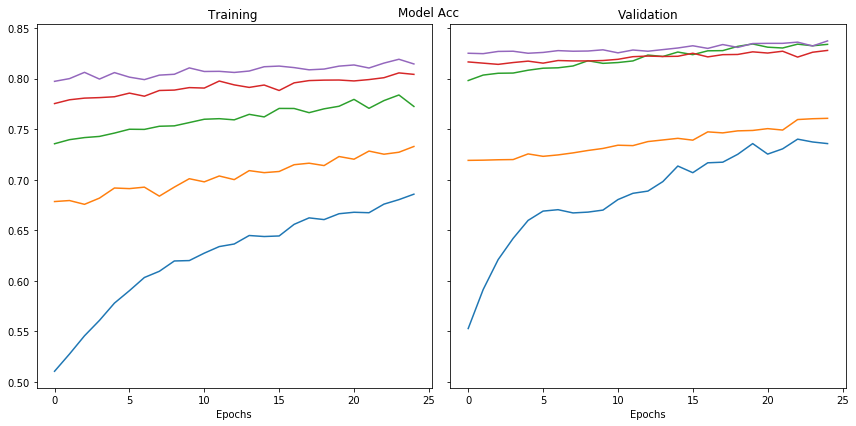

In [123]:
plot_accuracy(lstm_histories)

### GRU

In [81]:
gru_input_holder = Input(shape=(X_train.shape[1], ))
gru_embed = get_glove_embedding_layer(gru_input_holder)
x = GRU(25, dropout=0.2, recurrent_dropout=0.2)(gru_embed)
x = Dense(NUM_CLASSES, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(0.00001, 0.0001))(x)
gru_model = Model(inputs=gru_input_holder,outputs=x)
gru_model.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 800, 50)           5305950   
_________________________________________________________________
gru (GRU)                    (None, 25)                5700      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 5,311,702
Trainable params: 5,752
Non-trainable params: 5,305,950
_________________________________________________________________


In [82]:
gru_histories = run_model(gru_model)

Train on 10000 samples, validate on 2500 samples
Epoch 1/25
10000/10000 [==============================] - 106s 11ms/step - loss: 0.6877 - acc: 0.5549 - val_loss: 0.6686 - val_acc: 0.5900
Epoch 2/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.6402 - acc: 0.6332 - val_loss: 0.6000 - val_acc: 0.6848
Epoch 3/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.5639 - acc: 0.7166 - val_loss: 0.4799 - val_acc: 0.7800
Epoch 4/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.5223 - acc: 0.7500 - val_loss: 0.4619 - val_acc: 0.7848
Epoch 5/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.4905 - acc: 0.7657 - val_loss: 0.4128 - val_acc: 0.8178
Epoch 6/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.4706 - acc: 0.7833 - val_loss: 0.4002 - val_acc: 0.8254
Epoch 7/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.4561 - acc: 0.7907 - val_loss: 0.3

10000/10000 [==============================] - 103s 10ms/step - loss: 0.3237 - acc: 0.8606 - val_loss: 0.3014 - val_acc: 0.8720
Epoch 9/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.3212 - acc: 0.8598 - val_loss: 0.3079 - val_acc: 0.8678
Epoch 10/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.3164 - acc: 0.8683 - val_loss: 0.3054 - val_acc: 0.8696
Epoch 11/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.3170 - acc: 0.8649 - val_loss: 0.3004 - val_acc: 0.8708
Epoch 12/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.3184 - acc: 0.8607 - val_loss: 0.2999 - val_acc: 0.8726
Epoch 13/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.3180 - acc: 0.8632 - val_loss: 0.3011 - val_acc: 0.8686
Epoch 14/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.3131 - acc: 0.8659 - val_loss: 0.3028 - val_acc: 0.8680
Epoch 15/25
10000/10000 [========

10000/10000 [==============================] - 104s 10ms/step - loss: 0.2880 - acc: 0.8813 - val_loss: 0.2723 - val_acc: 0.8876
Epoch 17/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.2881 - acc: 0.8796 - val_loss: 0.2738 - val_acc: 0.8888
Epoch 18/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.2875 - acc: 0.8790 - val_loss: 0.2693 - val_acc: 0.8904
Epoch 19/25
10000/10000 [==============================] - 103s 10ms/step - loss: 0.2892 - acc: 0.8801 - val_loss: 0.2707 - val_acc: 0.8896
Epoch 20/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.2853 - acc: 0.8768 - val_loss: 0.2799 - val_acc: 0.8898
Epoch 21/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.2888 - acc: 0.8821 - val_loss: 0.2860 - val_acc: 0.8844
Epoch 22/25
10000/10000 [==============================] - 104s 10ms/step - loss: 0.2809 - acc: 0.8841 - val_loss: 0.2695 - val_acc: 0.8910
Epoch 23/25
10000/10000 [=======

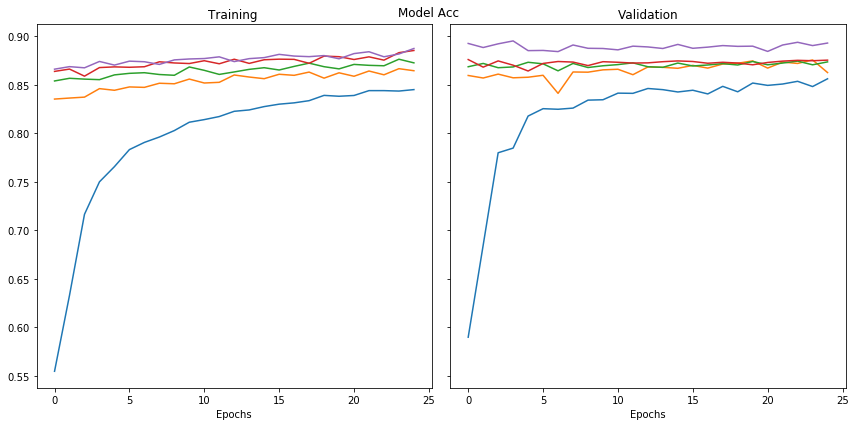

In [124]:
plot_accuracy(gru_histories)

### LSTM v. GRU Comparison

In [125]:
flat_lstm_histories = flatten(lstm_histories)
flat_gru_histories = flatten(gru_histories)

print("Normality Test")
print(stats.shapiro(flat_lstm_histories))
print(stats.shapiro(flat_gru_histories))
print()
print('LSTM v GRU')
print(stats.describe(flat_lstm_histories))
print(stats.describe(flat_gru_histories))
print(stats.ttest_rel(flat_lstm_histories, flat_gru_histories))

Normality Test
(0.8711528778076172, 0.2711235284805298)
(0.628416121006012, 0.0014575186651200056)

LSTM v GRU
DescribeResult(nobs=5, minmax=(0.5103, 0.7972), mean=0.6987300000000001, variance=0.013234464500000005, skewness=-0.9640789544677331, kurtosis=-0.518231627054738)
DescribeResult(nobs=5, minmax=(0.5549, 0.8661), mean=0.79383, variance=0.017969694500000008, skewness=-1.4734341145903556, kurtosis=0.21317961200359736)
Ttest_relResult(statistic=-4.725469484565645, pvalue=0.009134592724027916)


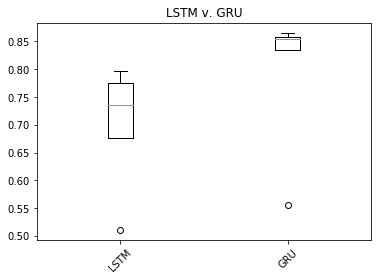

In [126]:
distributions = [flat_lstm_histories, flat_gru_histories]
plt.boxplot(distributions, labels=['LSTM', 'GRU'])
plt.xticks(rotation=45)
plt.title("LSTM v. GRU")
plt.show()

## Additional Recurrent Chain

In [85]:
x = GRU(25, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(gru_embed)
x = GRU(25, dropout=0.2, recurrent_dropout=0.2)(x)
x = Dense(NUM_CLASSES, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(0.00001, 0.0001))(x)
gru_model_2 = Model(inputs=gru_input_holder,outputs=x)
gru_model_2.compile(loss='binary_crossentropy', 
                    optimizer='rmsprop', 
                    metrics=['accuracy'])
gru_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 800, 50)           5305950   
_________________________________________________________________
gru_1 (GRU)                  (None, 800, 25)           5700      
_________________________________________________________________
gru_2 (GRU)                  (None, 25)                3825      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 52        
Total params: 5,315,527
Trainable params: 9,577
Non-trainable params: 5,305,950
_________________________________________________________________


In [86]:
gru_histories_2 = run_model(gru_model_2)

Train on 10000 samples, validate on 2500 samples
Epoch 1/25
10000/10000 [==============================] - 217s 22ms/step - loss: 0.6785 - acc: 0.5688 - val_loss: 0.6458 - val_acc: 0.6398
Epoch 2/25
10000/10000 [==============================] - 214s 21ms/step - loss: 0.6349 - acc: 0.6367 - val_loss: 0.5530 - val_acc: 0.7242
Epoch 3/25
10000/10000 [==============================] - 215s 21ms/step - loss: 0.5660 - acc: 0.7123 - val_loss: 0.4454 - val_acc: 0.7990
Epoch 4/25
10000/10000 [==============================] - 215s 22ms/step - loss: 0.5207 - acc: 0.7493 - val_loss: 0.4218 - val_acc: 0.8212
Epoch 5/25
10000/10000 [==============================] - 214s 21ms/step - loss: 0.4929 - acc: 0.7674 - val_loss: 0.3919 - val_acc: 0.8330
Epoch 6/25
10000/10000 [==============================] - 215s 21ms/step - loss: 0.4717 - acc: 0.7803 - val_loss: 0.3783 - val_acc: 0.8388
Epoch 7/25
10000/10000 [==============================] - 214s 21ms/step - loss: 0.4612 - acc: 0.7858 - val_loss: 0.3

10000/10000 [==============================] - 212s 21ms/step - loss: 0.3082 - acc: 0.8681 - val_loss: 0.2927 - val_acc: 0.8788
Epoch 10/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.3095 - acc: 0.8679 - val_loss: 0.2883 - val_acc: 0.8812
Epoch 11/25
10000/10000 [==============================] - 212s 21ms/step - loss: 0.3089 - acc: 0.8665 - val_loss: 0.2981 - val_acc: 0.8752
Epoch 12/25
10000/10000 [==============================] - 214s 21ms/step - loss: 0.3095 - acc: 0.8670 - val_loss: 0.2892 - val_acc: 0.8760
Epoch 13/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.3091 - acc: 0.8705 - val_loss: 0.2903 - val_acc: 0.8790
Epoch 14/25
10000/10000 [==============================] - 212s 21ms/step - loss: 0.3027 - acc: 0.8689 - val_loss: 0.2915 - val_acc: 0.8774
Epoch 15/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.2970 - acc: 0.8746 - val_loss: 0.2992 - val_acc: 0.8740
Epoch 16/25
10000/10000 [=======

10000/10000 [==============================] - 213s 21ms/step - loss: 0.2825 - acc: 0.8800 - val_loss: 0.2631 - val_acc: 0.8900
Epoch 18/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.2891 - acc: 0.8760 - val_loss: 0.2674 - val_acc: 0.8904
Epoch 19/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.2779 - acc: 0.8832 - val_loss: 0.2659 - val_acc: 0.8920
Epoch 20/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.2812 - acc: 0.8833 - val_loss: 0.2635 - val_acc: 0.8926
Epoch 21/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.2784 - acc: 0.8805 - val_loss: 0.2790 - val_acc: 0.8880
Epoch 22/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.2806 - acc: 0.8794 - val_loss: 0.2793 - val_acc: 0.8876
Epoch 23/25
10000/10000 [==============================] - 213s 21ms/step - loss: 0.2832 - acc: 0.8785 - val_loss: 0.2745 - val_acc: 0.8906
Epoch 24/25
10000/10000 [=======

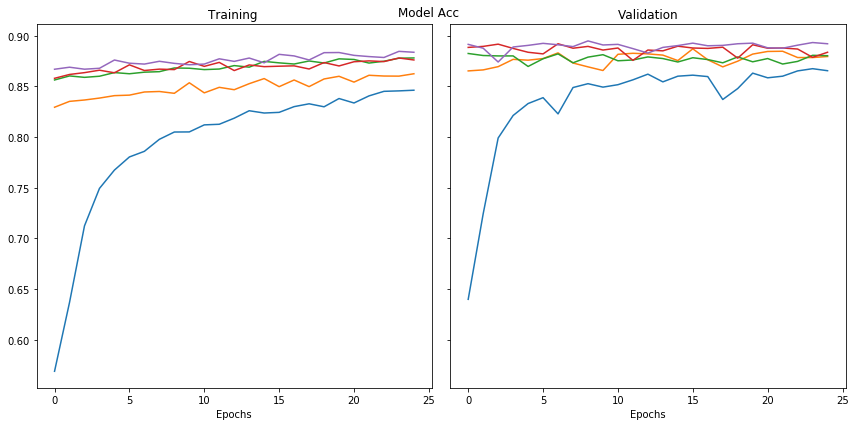

In [127]:
plot_accuracy(gru_histories_2)

### Comparison

In [128]:
flat_gru_histories_2 = flatten(gru_histories_2)

print("Normality Test")
print(stats.shapiro(flat_gru_histories_2))
print()
print('GRU v GRU2')
print(stats.describe(flat_gru_histories))
print(stats.describe(flat_gru_histories_2))
print(stats.ttest_rel(flat_gru_histories, flat_gru_histories_2))

Normality Test
(0.6443394422531128, 0.0022804047912359238)

GRU v GRU2
DescribeResult(nobs=5, minmax=(0.5549, 0.8661), mean=0.79383, variance=0.017969694500000008, skewness=-1.4734341145903556, kurtosis=0.21317961200359736)
DescribeResult(nobs=5, minmax=(0.5688, 0.86685), mean=0.7958299999999999, variance=0.016303328250000002, skewness=-1.4563167683313163, kurtosis=0.18793455957359173)
Ttest_relResult(statistic=-0.6093357044324321, pvalue=0.575214610593697)


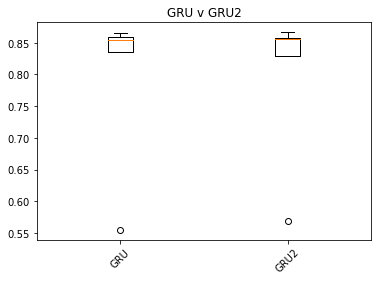

In [129]:
distributions = [flat_gru_histories, flat_gru_histories_2]
plt.boxplot(distributions, labels=['GRU', 'GRU2'])
plt.xticks(rotation=45)
plt.title('GRU v GRU2')
plt.show()

# Exceptional work

### Visualizing the model

In [194]:
gru_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 800, 50)           5305950   
_________________________________________________________________
gru_1 (GRU)                  (None, 800, 25)           5700      
_________________________________________________________________
gru_2 (GRU)                  (None, 25)                3825      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 52        
Total params: 5,315,527
Trainable params: 9,577
Non-trainable params: 5,305,950
_________________________________________________________________


### Get embedding weights

From the model summary above we see that we have to extract the weights from the second layer (1st in zeroed notation)

In [195]:
# get embedding layer
emb_layer = gru_model_2.layers[1]
emb_weights = np.array(emb_layer.get_weights()).reshape(106119, 50)
print(emb_weights.shape)

(106119, 50)


Therefore each word is embedded int a 50 dimensional array.

### UMAP Dimensionality reduction of the Embedding

We reduce the 50 dimension to 2 using UMAP in order to visualize the geometrical relationships between words and how they correlate with semantic relationships.

In [196]:
import umap

In [197]:
reducer = umap.UMAP(n_components=2)
red_emb = reducer.fit_transform(emb_weights)
print(red_emb.shape)

(106119, 2)


In [198]:
word_index
red_words = {k: word_index[k] for k in list(word_index)[:5000]}

In [199]:
# Genre analysis
genres = ['horror', 'thriller', 'crime', 'western', 'action', 'comedy', 'romance', 'fiction', 'fantasy', 'animation', 'historical', 'documentary', 'drama', 'science']

temp = []
for g in genres:
    temp.append([value for key, value in red_words.items() if g == key])

g_values = []
for t in temp[:]:
    g_values.append(t[0])
    

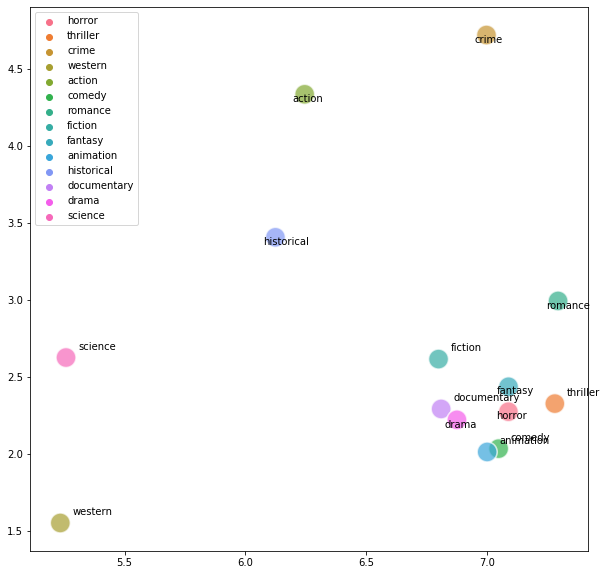

In [207]:
mer = red_emb[g_values]
sns.color_palette("Paired")
plt.figure(figsize=[10, 10])
sns.scatterplot(mer[:,0], mer[:,1], alpha=0.7, s=400, hue=genres)
for i in range(len(genres)):
    if (i % 2) == 0:
        adj = float(-0.05)
    else:
        adj = float(0.05)
    plt.text(x=mer[i,0]+adj, y=mer[i,1]+adj, s=genres[i])
plt.show()

In [201]:
moods = ['fantastic', 'incredible', 'awesome', 'great', 'good', 'ok', 'alright', 'bad', 'awful', 'disappointing', 'worst', 'disgusting']

temp = []
for m in moods:
    temp.append([value for key, value in red_words.items() if m == key])
    
m_values = []
for t in temp:
    m_values.append(t[0])

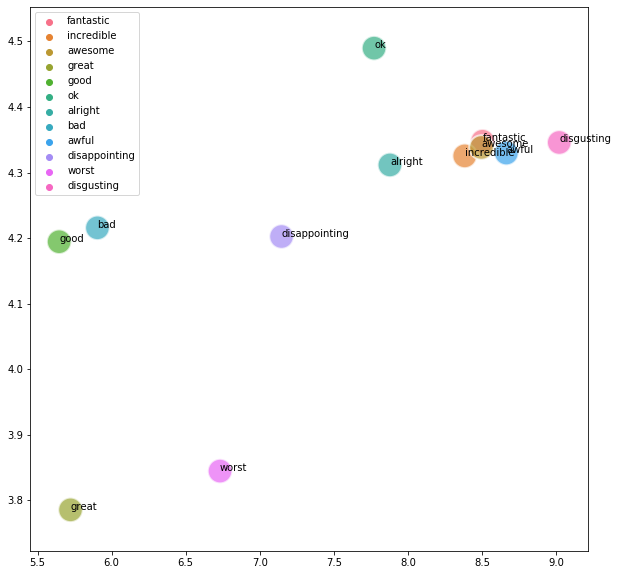

In [209]:
mood = red_emb[m_values]
sns.color_palette("Paired")
plt.figure(figsize=[10, 10])
sns.scatterplot(mood[:,0], mood[:,1], alpha=0.7, s=600, hue=moods)
for i in range(len(moods)):
    if (i % 2) == 0:
        adj = float(+0.05)
    else:
        adj = float(-0.05)
    plt.text(x=mood[i,0], y=mood[i,1], s=moods[i])
plt.show()

### Analysis of "synonym space" of the moods words

It is interesting the words spacially close to the key mood words selected in the embedding are meaningfully close to it as well. We performed a distance analysis and extracted the key values. We observe that in most cases the words found are synonym of close meaning-wise. This result indicate that our model well transpose semantic relationships between words into geometrical relationships in the embedding.

In [203]:
def distance(p1, p2):
    x1, x2, y1, y2 = p1[0], p2[0], p1[1], p2[1]
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist
    
def top_closest(indx, emb):
    ref = emb[indx]
    dist = [distance(ref, p) for p in emb]
    sort_dist = np.argsort(dist)
    return sort_dist[1:11]

def get_key(val, dic):

    ret = []
    for key, value in dic.items():
        for v in val:
            if v == value:
                ret.append(key)
    return ret

print('Reference', '     Predicted Synonyms')
for i in m_values:
    ref_key = [key for key, value in red_words.items() if i == value]
    values = top_closest(i, red_emb)
    print(str(ref_key), '   ', get_key(values, red_words))


Reference      Predicted Synonyms
['fantastic']     ['amazing', 'awesome', 'terrific', 'unbelievable', 'tragic', 'amazed', 'annoyed']
['incredible']     ['strange', 'unfortunate']
['awesome']     ['amazing', 'fantastic', 'terrific', 'unbelievable', 'tragic', 'amazed']
['great']     ['quick', 'remain', 'send', 'latest', 'term', 'figures', 'prepare']
['good']     ['see', 'person', 'doing']
['ok']     ['sex', 'yeah', 'hey', 'gonna', 'regret', 'gotta']
['alright']     ['emotion', 'bitter']
['bad']     ['seems', 'seem', 'unless', 'pro']
['awful']     ['interesting', 'exciting', 'ugly', 'shocking']
['disappointing']     ['bother', 'innocent', 'wondered']
['worst']     ['tells', 'witnessed']
['disgusting']     ['scary', 'predictable', 'physically']
